# TITANIC DATASET ANALYSIS

#### Import necessary libraries

In [331]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import AllKNN


#### Load the dataset into a dataframe

In [332]:
data = pd.read_csv('titanic.csv')
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


#### Data description

We can use the `describe()` method to get a summary of the numerical attributes of the dataset. This will help us to understand the data better.

In [333]:
data.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881138,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413493,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


The `info()` method will give us a concise summary of the dataframe, including the number of non-null values in each column as well as the data type of each column.

In [334]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In order to understand what features we may have to clean, as there might be missing values, we can use the code below to get the percentage of NaN values in each column.

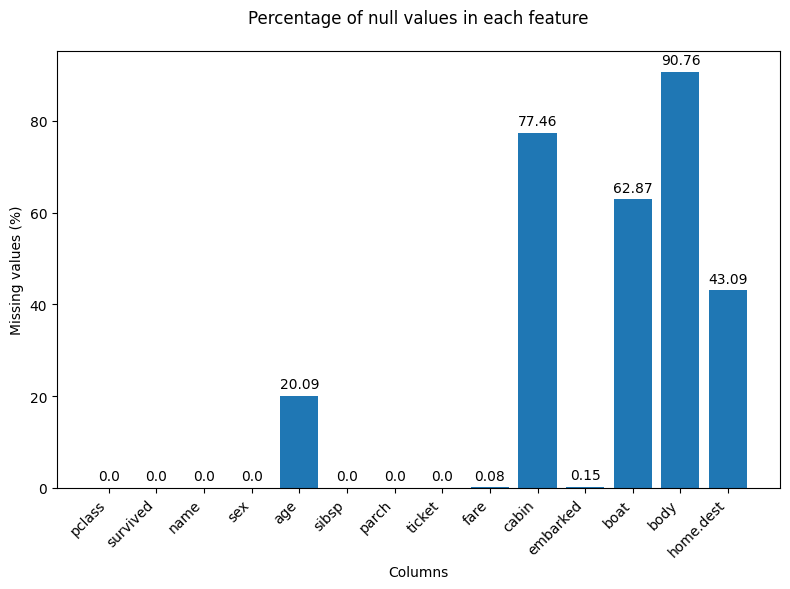

In [335]:
# Calculate the percentage of missing values in each column
missing_data = data.isna().sum() / len(data) * 100

# Create a bar graph
plt.figure(figsize=(8, 6))
bars = plt.bar(missing_data.index, missing_data.values)
plt.title('Percentage of null values in each feature', pad=20)
plt.xlabel('Columns')
plt.ylabel('Missing values (%)')

plt.xticks(rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

##### NaN values
Upon reviewing the dataset, we noted a significant number of NaN values in the `body`, `boat`, and `cabin` columns. Given their high percentage of NaN values, we decided to drop these columns as they wouldn't contribute meaningfully to our analysis. Although the `age`, `home.dest`, `embarked` and `fare` columns also contained some missing data, falling under 50%, we needed to think how we would handle them. We resolved to drop the `home.dest` column due to its limited relevance to our analysis. For the `age` column we thought of filling those values with the mean of the column but for a more filtered approach we decided to fill the missing values with the mean of the ages of the passengers in the same class. In the `embarked` column, we addressed missing values by substituting them with the column's most frequent value and similarly to the `age` feature, for the `fare` column, we replaced missing entries with the column's mean value.

##### Data cleaning
After addressing the features with a significat percentage of NaN values, we turned our attention to the other columns. Upon consideration, we determined that the `name` column served no significant purpose for our analysis decideding to drop it. Similarly, we chose to remove the `ticket` column as it merely serves as a unique identifier for each passenger and does not offer valuable insights. Additionally, recognizing the presence of categorical features, we proceeded to convert them into numerical values using the `get_dummies()` method. Specifically, the `sex` and `embarked` columns were converted into multiple boolean columns. For the `sex` column, it created two new columns: `sex_male` and `sex_female`, where a `true` represents the presence of that category and a `false` represents the absence. Similarly, for the `embarked` column, it created three new columns: `embarked_C`, `embarked_Q`, and `embarked_S`, each representing one of the original categories.

In [336]:
# Changing the Nan values in the age column to the mean of the age of the respective class
data['age'] = data.groupby('pclass')['age'].transform(lambda x: x.fillna(x.mean()))

# Changing the Nan values in the fare column to the mean
data['fare'] = data['fare'].fillna(data['fare'].dropna().mean())

# Changing the Nan values in the embarked column to the mode
data['embarked'] = data['embarked'].fillna(data['embarked'].dropna().mode()[0])

# Dropping the body, boat, cabin and home.dest columns
processed_data = data.drop([
    'boat', 
    'body', 
    'cabin', 
    'home.dest',
    'name',
    'ticket'
], axis=1) 


processed_data = pd.get_dummies(processed_data)
processed_data.head()




,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,1,1,29.00,0,0,211.3375,True,False,False,False,True
1,1,1,0.92,1,2,151.5500,False,True,False,False,True
2,1,0,2.00,1,2,151.5500,True,False,False,False,True
3,1,0,30.00,1,2,151.5500,False,True,False,False,True
4,1,0,25.00,1,2,151.5500,True,False,False,False,True


Although the dataset was basically clean, we still made some changes. We needed to drop one of `sex_male` and `sex_female` columns to avoid multicollinearity as they are inversely related and we also decided to merge `sibsp` and `parch` columns into a single column called `family` that represents the number of family members on board. Similarly, with the `sex_male` and `sex_female` columns, we dropped one of the `embarked_C`, `embarked_Q`, and `embarked_S` columns to avoid multicollinearity.

We can test if we can remove the `embarked` column by checking if there is any case where all the values of the 'embarked' columns are `False` . If there is, we cannot remove the columns, since it means we cannot predict the value of the dropped column from the other columns.

In [337]:
mask = (processed_data['embarked_C'] == False) & (processed_data['embarked_Q'] == False) & (processed_data['embarked_S'] == False)
rows_with_all_false = processed_data[mask]

if not rows_with_all_false.empty:
    print("Exists rows where all columns are False.")
else:
    print("There are no rows where all columns are False.")

There are no rows where all columns are False.


Since there are no rows where all columns are False, we can safely drop one of the columns. If both `embarked_S` and `embarked_Q` are `False`, then `embarked_C` is `True`. So we can drop `embarked_C` column.

Finally, since we will merge `sibsp` and `parch` columns into a single column called `family`, we can drop the `sibsp` and `parch` columns.

In [338]:
processed_data['family'] = processed_data['sibsp'] + processed_data['parch']

processed_data = processed_data.drop([
    'sex_male',
    'sibsp',
    'parch',
    'embarked_C'
], axis=1)


processed_data.head()


,pclass,survived,age,fare,sex_female,embarked_Q,embarked_S,family
0,1,1,29.00,211.3375,True,False,True,0
1,1,1,0.92,151.5500,False,False,True,3
2,1,0,2.00,151.5500,True,False,True,3
3,1,0,30.00,151.5500,False,False,True,3
4,1,0,25.00,151.5500,True,False,True,3


So in order to understand how those features are related to the survival rate, we ploted a graph to show how the features are distributaded based on the survival rate.

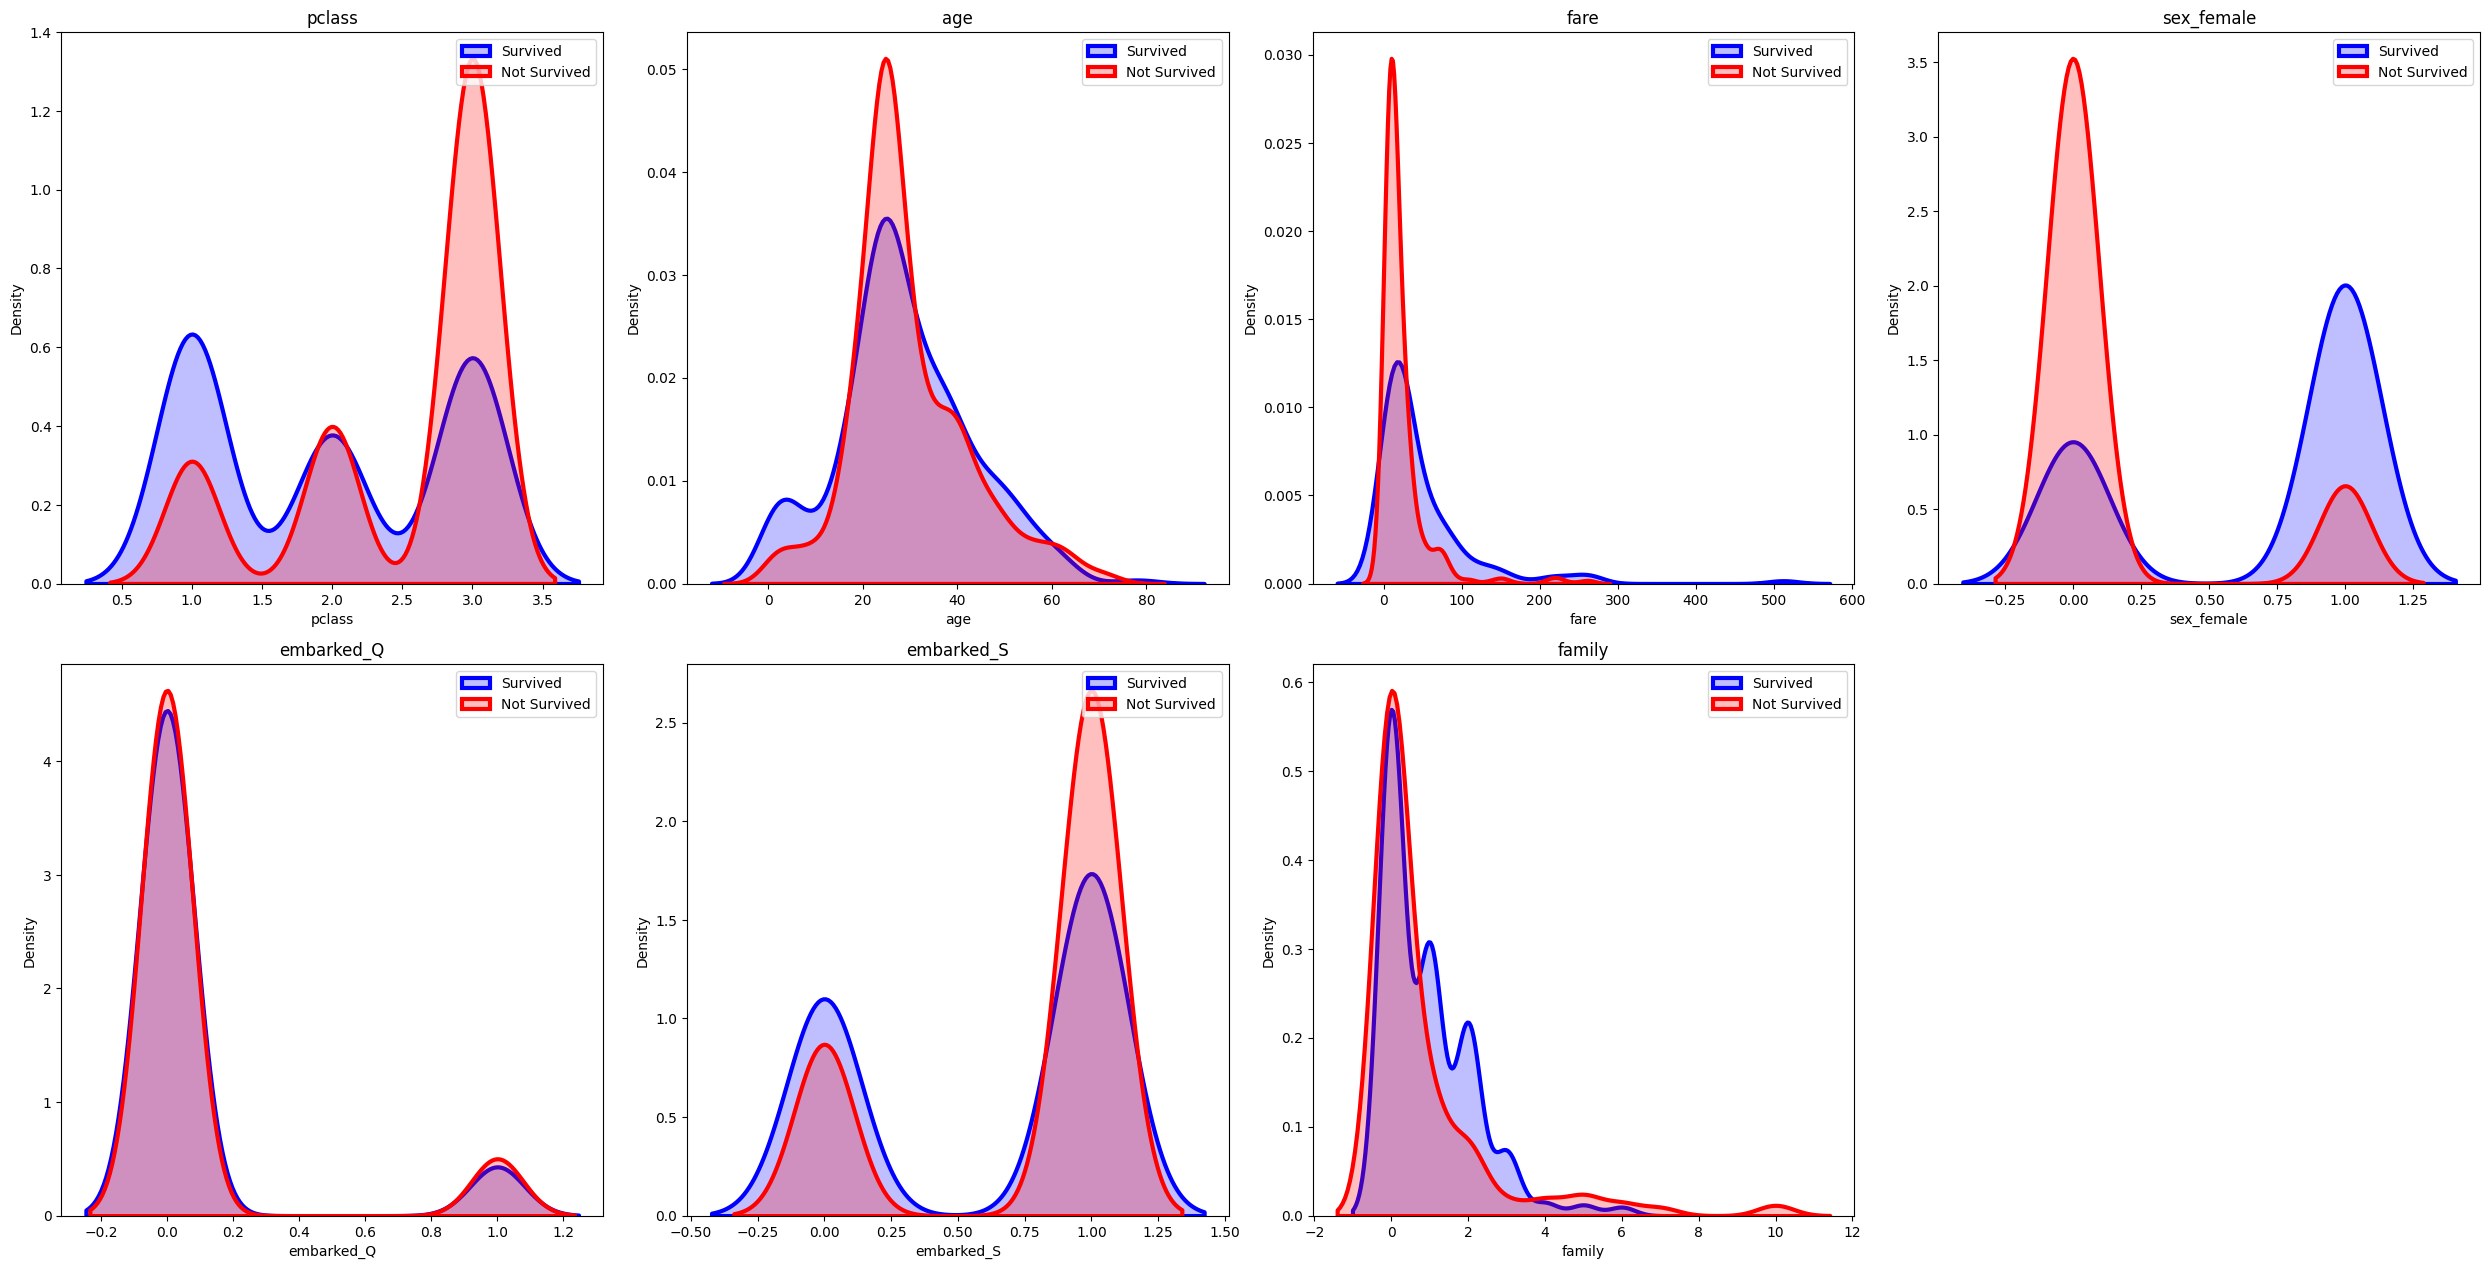

In [339]:
plt.figure(figsize=(25,25))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# Create dataframes for survived and not survived
pd1 = processed_data[processed_data['survived']==1].drop(['survived'],axis=1)
pd2 = processed_data[processed_data['survived']==0].drop(['survived'],axis=1)

for i, col in enumerate(list(pd1.columns)):
    plt.subplot(4, 4, i+1)
    
    # Use seaborn kdeplot which allows you to draw a line at the mean
    sb.kdeplot(pd1[col], fill=True, linewidth=3, color='blue', label='Survived')
    sb.kdeplot(pd2[col], fill=True, linewidth=3, color='red', label='Not Survived')
    
    plt.legend(prop={'size': 10})
    plt.title(col)

plt.tight_layout()
plt.show()

Now to verify numerically the correlation between the features and the survival rate, we used the `corr()` method to calculate the correlation between the features and the target variable. We then plotted a heatmap to visualize the correlation between the features and the target variable.

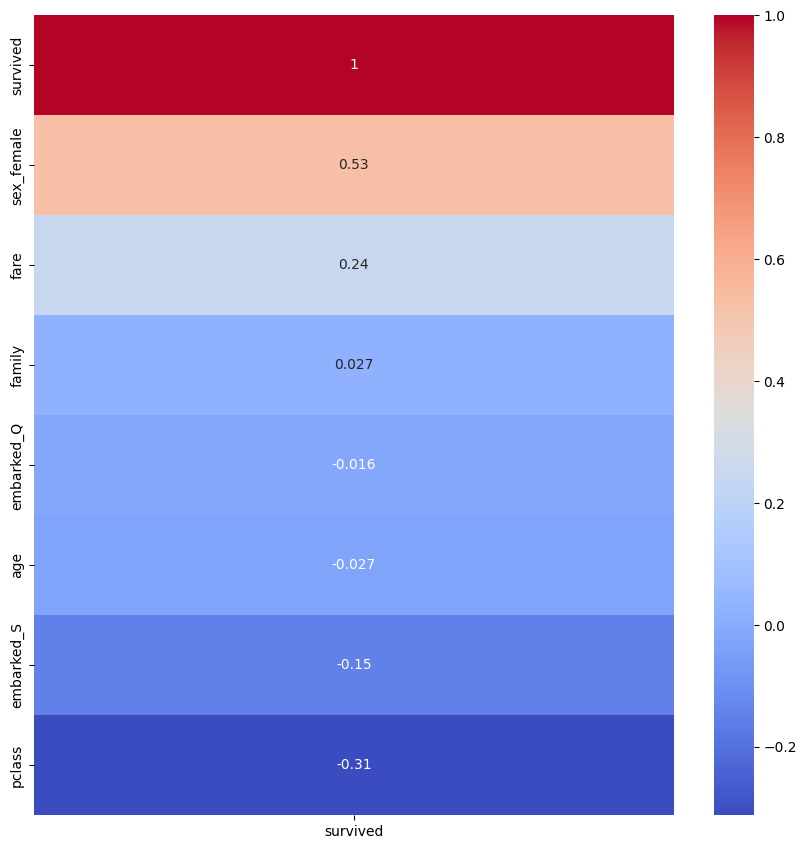

In [340]:
cols = list(processed_data.columns)
plt.figure(figsize=(10,10))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

corr = processed_data.corr()[['survived']].sort_values(by='survived', ascending=False)
sb.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

The heatmap made above show the correlation, numerically, between the features and the target variable. A positive value indicates that when the feature increases, the target variable also increases. A negative value indicates that when the feature increases, the target variable decreases. A value of 0 indicates no correlation between the feature and the target variable.

Analyzing the heatmap and and the graphs above, we can check that:  

- The `survived` column is obviously correlated with itself, so it has a correlation of 1. 
- As expected, the `sex_female` column has a high positive correlation with the `survived` column, indicating that women were more likely to survive. This confirms that women were prioritized during the evacuation. In the graphs we can also check that there are a lot of dead men, a number about seven times bigger than the number of dead women; 
- The `fare` column has a high correlation with the `survived` column, indicating that people who paid more for the ticket were more likely to survive. This was not expected, but it is possible that people who paid more for the ticket were in a better location in the ship, which could have helped them to survive. In the graphs we can even confirm that there wasn't a single death for people who paid more than 300 for the ticket.
- The `pclass` column has a high negative correlation with the `survived` column. This indicates that people in the first class were more likely to survive. However, in the graphs we can observe that the number of people who survived in all classes is very similar. The number of people who died in the third class is a lot bigger than the number of people who died in the first and second class, but this can be explained by the fact that there were more people in the third class than in the other classes.
- The other columns have a low correlation with the `survived` column, indicating that they don't have a significant impact on the survival rate. 
- It's curious that the correlation with the `embarked_Q` column and the `embarked_S` column are different. Both have negative correlation with the `survived` column, but the `embarked_Q` column has a higher correlation than the `embarked_S` column. This is interesting because the number of people who embarked in `Q` is a lot smaller than the number of people who embarked in `S`. This could indicate that people who embarked in `Q` were more likely to die than people who embarked in `S`. 
- Other interesting point is that the `family` column has a close to zero correlation with the `survived` column, indicating that the number of family members on board doesn't have a significant impact on the survival rate. However, by visualizing the graphs it is understandable that people with a family size bigger than 4 were more likely to not survive. All families with 7 or more members have died.

## Data analysis

In [341]:
# Splitting the data into features and target
X = processed_data.drop('survived', axis=1)
y = processed_data['survived']

##### Train-test split



In [342]:
unique, counts = np.unique(y, return_counts=True)
result = dict(zip(unique, counts))
print(result)

{0: 809, 1: 500}


In order to split the data into training data and testing data we used the `train_test_split()` method from the `sklearn.model_selection` module to split the data into 80% training and 20% testing sets. This allowed us to train our model on the training set and evaluate its performance on the testing set. We defined `random_state = 42` to ensure reproducibility of the results.

Considering our dataset is quiet unbalanced, having 62% of the people not surviving, we decided to test the models with two different approaches availble. Those were:

- `Oversampling`: This involves increasing the number of instances in the minority class by randomly replicating them in order to present a higher representation of the minority class in the dataset. We used `SMOTE` from the `imblearn.over_sampling` module to perform oversampling;

- `Stratified sampling`: This involves splitting the dataset into training and testing sets while maintaining the same class distribution in both sets. We used the `stratify` parameter in the `train_test_split()` method to perform stratified sampling.


In [343]:
# Sample with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Sampling with SMOTE
smote = SMOTE()
X_trainSmote, y_trainSmote = smote.fit_resample(X_train, y_train)
X_trainSmote, X_testSmote, y_trainSmote, y_testSmote = train_test_split(X_trainSmote, y_trainSmote, test_size=0.2, random_state=42)

# Sampling with AllKNN
allknn = AllKNN()
X_trainAllKNN, y_trainAllKNN = allknn.fit_resample(X_train, y_train)
X_trainAllKNN, X_testAllKNN, y_trainAllKNN, y_testAllKNN = train_test_split(X_trainAllKNN, y_trainAllKNN, test_size=0.2, random_state=42)

So we can simplify and only use one of the approaches in order to do a deep analisys, we will compare the `accuracy`, `precision`, `recall`, `f1-score` and `roc-auc` of the models using the different approaches and choose the best one.

In [344]:
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Extra Trees', ExtraTreesClassifier()),
    ('MLP', MLPClassifier(random_state=42, max_iter=1000)),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC()),
    ('Gaussian Naive Bayes', GaussianNB()),
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('Bernoulli Naive Bayes', BernoulliNB()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

# Define the sampling techniques
sampling_techniques = {
    'Stratified': (X_train, X_test, y_train, y_test),
    'SMOTE': (X_trainSmote, X_testSmote, y_trainSmote, y_testSmote),
    'AllKNN': (X_trainAllKNN, X_testAllKNN, y_trainAllKNN, y_testAllKNN)
}

# Store the results
results = []

# For each sampling technique
for sampling_name, (X_train, X_test, y_train, y_test) in sampling_techniques.items():
    # For each model
    for model_name, model in models:
        # Train the model
        model.fit(X_train, y_train)
        # Make predictions
        y_pred = model.predict(X_test)
        # Calculate the accuracy
        accuracy = accuracy_score(y_test, y_pred)
        # Store the results
        results.append((sampling_name, model_name, accuracy))

# Convert the results to a DataFrame
results_df = pd.DataFrame(results, columns=['Sampling Technique', 'Model', 'Accuracy'])

pivot_df = results_df.pivot(index='Model', columns='Sampling Technique', values='Accuracy')

# Display the pivoted DataFrame
display(pivot_df)

# Calculate the mean accuracy for each sampling technique
mean_accuracy = results_df.groupby('Sampling Technique')['Accuracy'].mean()

# Display the mean accuracy
display(mean_accuracy.sort_values(ascending=False))

Sampling Technique,AllKNN,SMOTE,Stratified
Model,,,
Bernoulli Naive Bayes,0.830065,0.756757,0.801527
Decision Tree,0.862745,0.741313,0.790076
Extra Trees,0.888889,0.779923,0.770992
Gaussian Naive Bayes,0.816993,0.737452,0.786260
Gradient Boosting,0.869281,0.776062,0.839695
KNN,0.790850,0.718147,0.702290
Logistic Regression,0.823529,0.745174,0.816794
MLP,0.862745,0.737452,0.816794
Multinomial Naive Bayes,0.705882,0.640927,0.675573


Sampling Technique
AllKNN        0.822341
Stratified    0.769257
SMOTE         0.732187
Name: Accuracy, dtype: float64

In order to evaluate how well our model performs, we used the `classification_report()` and `accuracy_score` methods from the `sklearn.metrics` module to generate a classification report. This report provides a summary of the `accuracy`, `precision`, `recall`, `F1-score`, and `support` for each class in the dataset:

- `Accuracy`: The ratio of correctly predicted observations to the total observations. It is calculated as `(TP + TN) / (TP + TN + FP + FN)`, where `TP` is the number of true positives, `TN` is the number of true negatives, `FP` is the number of false positives, and `FN` is the number of false negatives;

- `Precision`: The ratio of correctly predicted positive observations to the total predicted positive observations. It is calculated as `TP / (TP + FP)`, where `TP` is the number of true positives and `FP` is the number of false positives and indicates the number of positive instances that were correctly classified as positive;

- `Recall`: The ratio of correctly predicted positive observations to the all observations in actual class. It is calculated as `TP / (TP + FN)`, where `FN` is the number of false negatives and means the number of positive instances that were incorrectly classified as negative;

- `F1-score`: The weighted average of precision and recall. It is calculated as `2 * (precision * recall) / (precision + recall)` and indicates the balance between precision and recall;

- `Support`: The number of actual occurrences of the class in the specified dataset.

##### Model Tuning and accuracy comparison

For each model we used the `GridSearchCV()` method from the `sklearn.model_selection` module to perform a grid search with cross-validation. This method works by training the model on different combinations of hyperparameters and evaluates the model using cross-validation. We defined the hyperparameters we wanted to test and the number of folds for the cross-validation. We then used the `best_params` that were returned to get the best hyperparameters for each model and compared the resulting accuracy with the accuracy of the default model.

##### Logistic regression

`Logistic regression` stands as a supervised learning algorithm within machine learning. It excels in classification tasks, particularly those with binary outcomes. The model functions by establishing a linear decision boundary within the feature space. This boundary effectively separates the two target categories, allowing for the classification of new data points based on their relative position. It calculates the probability of an instance belonging to a specific class. This probability is then translated into a binary classification through a predefined threshold. Data points with probabilities exceeding the threshold are assigned to the first class, while those falling below are classified into the second.

In [345]:
# Define the parameter grid
param_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'max_iter': list(range(100,1000,100))},
    {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'max_iter': list(range(100,1000,100))}
]

logreg = LogisticRegression()

grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

# Train the model using the best parameters
model = LogisticRegression(max_iter=best_params['max_iter'], C=best_params['C'], penalty=best_params['penalty'], solver=best_params['solver'])
model.fit(X_train, y_train)

# Make predictions and calculate accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


/home/tomas/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tomas/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tomas/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tomas/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tomas/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tomas/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: Con

Accuracy: 0.8235294117647058


/home/tomas/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tomas/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tomas/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tomas/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tomas/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tomas/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: Con

In [346]:

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions and calculate accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy}')

              precision    recall  f1-score   support

           0       0.78      0.88      0.83        73
           1       0.87      0.78      0.82        80

    accuracy                           0.82       153
   macro avg       0.83      0.83      0.82       153
weighted avg       0.83      0.82      0.82       153

Accuracy: 0.8235294117647058


##### Decision Tree

`Decision Trees` function as a supervised learning methodology adept at classification tasks. These algorithms present a tree-like structure, where internal nodes represent decision points based on specific features of the data. At each node, a question is posed, directing the data point down a binary path ("yes" or " "no") based on its attribute values. This iterative process of inquiry continues until the data point reaches a terminal node, also known as a leaf node, signifying its assigned classification.

In [347]:

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 11)),
    'min_samples_split': list(range(2, 11)),
    'min_samples_leaf': list(range(1, 11))
}

# Create a base model
model = DecisionTreeClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model using the best parameters
model = DecisionTreeClassifier(criterion=best_params['criterion'], max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], min_samples_leaf=best_params['min_samples_leaf'])
model.fit(X_train, y_train)

# Make predictions and calculate accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Best parameters: {best_params}')
print(f'Accuracy: {accuracy}')

Best parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 10}
Accuracy: 0.8366013071895425


In [348]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.869281045751634


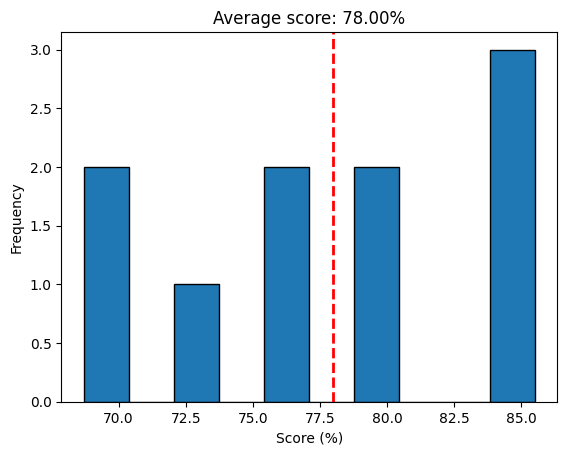

In [349]:
n_splits = 10

decision_tree_classifier = DecisionTreeClassifier(max_depth=1)

cv_scores = cross_val_score(decision_tree_classifier, X, y, cv=n_splits) * 100

average_score = np.mean(cv_scores)

# Create a histogram of the cross-validation scores
plt.hist(cv_scores, edgecolor='black')
plt.title(f'Average score: {average_score:.2f}%')
plt.xlabel('Score (%)')
plt.ylabel('Frequency')
plt.axvline(average_score, color='r', linestyle='dashed', linewidth=2)  # Add a vertical line at the average score
plt.show()

Best score: 0.7875220199647681
Best parameters: {'max_depth': 5, 'max_features': 5}


Text(50.722222222222214, 0.5, 'max_depth')

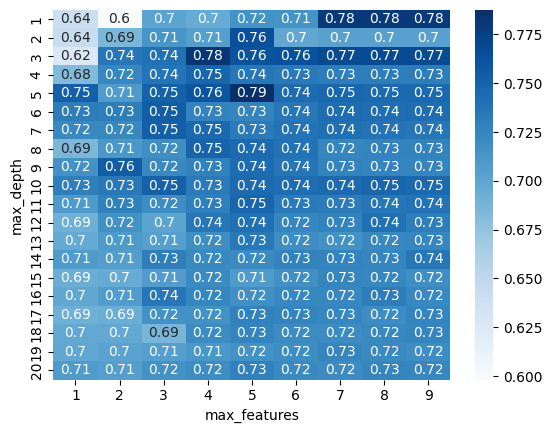

In [350]:

from sklearn.model_selection import GridSearchCV

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 
                  'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV( decision_tree_classifier, param_grid=parameter_grid, cv=cross_validation)

grid_search.fit(X, y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))


grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (20, 9)
sb.heatmap(grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(9) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(20) + 0.5, grid_search.param_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')

##### Random Forest

A `Random Forest` is a machine learning algorithm that operates by constructing multiple decision trees. Each tree in the forest considers a random subset of features, adding an element of randomness to the model. The final classification is determined by aggregating the predictions of each tree, with the most popular class being selected as the final output.

In [351]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8823529411764706


##### Extra Trees

`Extra Trees` is a type of learning technique that is fundamentally similar to a Random Forest. The primary distinction between the two lies in the way the algorithm chooses the value at which to split each feature. While Random Forests uses a greedy approach, Extra Trees opt for a random split.

In [352]:
model = ExtraTreesClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8954248366013072


##### MLP

`MLP` stands for Multi-Layer Perceptron, which is a type of neural network. This type of model is inspired by the human brain and is composed of multiple layers of neurons. Each neuron in a layer is connected to every neuron in the subsequent layer. The model learns by adjusting the weights of the connections between neurons to minimize the error in the predictions. 

In [353]:
model = MLPClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8627450980392157


##### K-Nearest Neighbors

`K-Nearest Neighbors (KNN)` is a type of instance-based learning, or lazy learning, where it assumes that similar things exist in close proximity. In other words, data points that are similar, are located close to each other. One of the issues of this algorithm is choosing the correct `k`. This value is a user-defined number that represents the number of neighbors to consider when classifying a new data point. A small `k` value can lead to noise in the classification, while a large `k` value can lead to misclassification. This value come is usually a odd number to avoid ties and is defined by default as 5 if not specified.

In [354]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7908496732026143


##### SVM

`Support Vector Machines` are a type of supervised learning algorithm that can be used for both classification and regression challenges. All in all, the SVM algorithm aims to find the hyperplane that best separates the data points into two classes, more or less like the logistic regression, being the main difference the approach to find the best hyperplane. Whereas the losgistic regression utilizes a probabilistic approach, the SVM algorithm aims to maximize the margin between the two classes. Graphically, the hyperplane would be like a line in which the distance between the line and the nearest point of each class is maximized.

In [355]:
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7124183006535948


##### Naive Bayes

`Naive Bayes` is a classification technique based on Bayes' Theorem which assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. There are different Naive Bayes classifiers, such as Gaussian Naive Bayes, Multinomial Naive Bayes, and Bernoulli Naive Bayes. The difference between them lies in the assumption made about the distribution of the data.

- Gaussian NB: assumes that the features follow a normal distribution.
- Multinomial NB: assumes that the features are multinomially distributed.
- Bernoulli NB: assumes that the features are binary.

In [356]:
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy GaussianNB: {accuracy}')

Accuracy GaussianNB: 0.8169934640522876


In [357]:
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy MultinomialNB: {accuracy}')

Accuracy MultinomialNB: 0.7058823529411765


In [358]:
model = BernoulliNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy BernoulliNB: {accuracy}')

Accuracy BernoulliNB: 0.8300653594771242


##### Gradient Boosting

`Gradient Boosting` is a machine learning technique, which combine multiple weak learners to create a strong learner. Those weak learners are usually decision trees and this new model is trained so that it corrects the errors made by the previous model. This process is repeated until the model can't be improved anymore or until a criteria is met. Basically, the model is trained in a stage-wise fashion, where various trees are built sequentially, each tree correcting the errors of the previous one.

In [359]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.869281045751634


In [360]:
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Extra Trees', ExtraTreesClassifier()),
    ('MLP', MLPClassifier(random_state=42)),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC()),
    ('Gaussian Naive Bayes', GaussianNB()),
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('Bernoulli Naive Bayes', BernoulliNB()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

models_dict = {}

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    models_dict[name] = (model, accuracy)

models_dict = dict(sorted(models_dict.items(), key=lambda item: item[1][1], reverse=True))

best_model_name, (best_model, best_model_accuracy) = next(iter(models_dict.items()))

results = pd.DataFrame([(name, accuracy) for name, (model, accuracy) in models_dict.items()], columns=['Model', 'Accuracy'])
display(results)

,Model,Accuracy
0,Random Forest,0.895425
1,Extra Trees,0.895425
2,Gradient Boosting,0.869281
3,Decision Tree,0.862745
4,MLP,0.862745
5,Bernoulli Naive Bayes,0.830065
6,Logistic Regression,0.823529
7,Gaussian Naive Bayes,0.816993
8,KNN,0.790850
9,SVM,0.712418


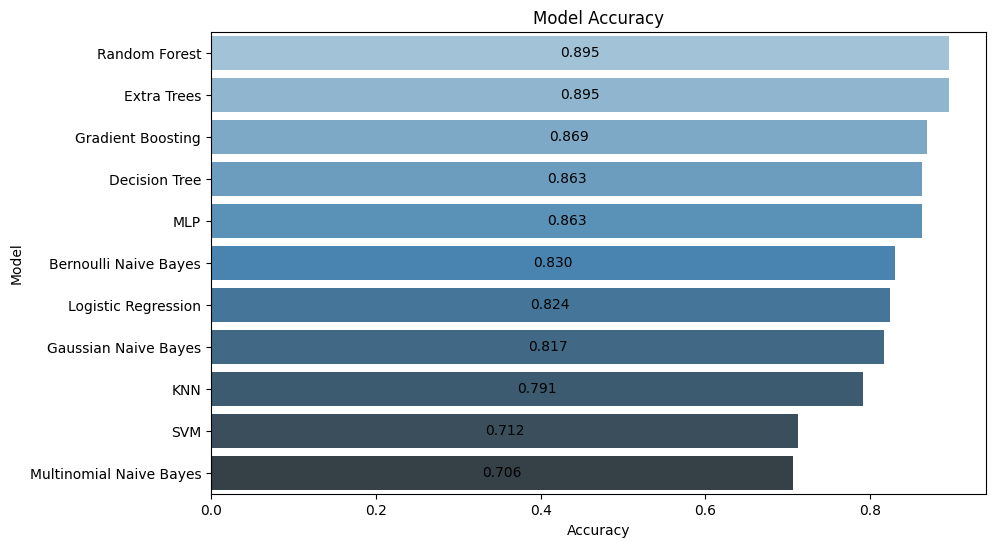

In [361]:
plt.figure(figsize=(10, 6))
barplot = sb.barplot(x='Accuracy', y='Model', hue='Model', data=results, palette='Blues_d', errorbar=None)

for p in barplot.patches:
    width = p.get_width()
    plt.text(width / 2,  
             p.get_y() + p.get_height() / 2,
             '{:1.3f}'.format(width),
             ha = 'center',
             va = 'center')

plt.title('Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()

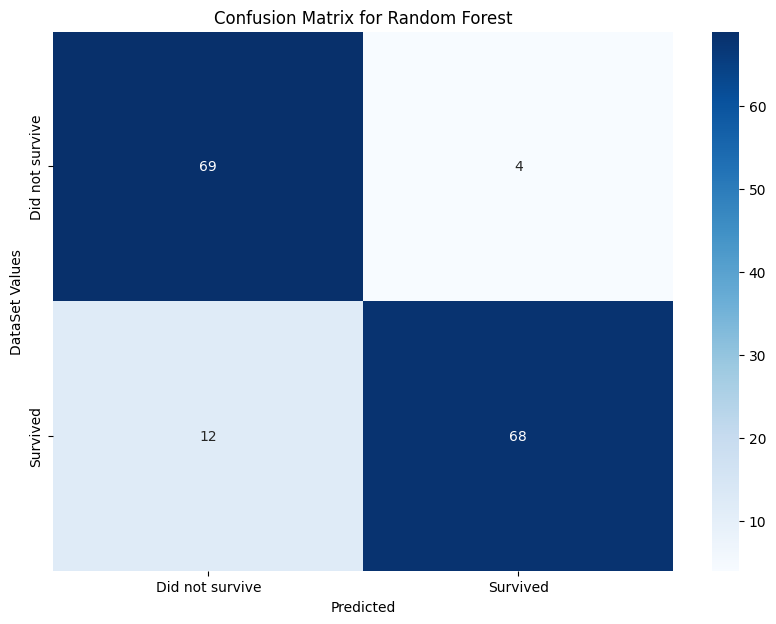

In [362]:
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Did not survive', 'Survived'], yticklabels=['Did not survive', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('DataSet Values')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()